Examples of how to work with the combined FLEX and SGA datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import h5py

In [2]:
flexdata = pd.read_hdf('FLEX_measurements.h5', key='galaxies')
flexdata = pd.read_hdf('FLEX_measurements.h5', key='galaxies')
print('SGA-flex data model version ',h5py.File('FLEX_measurements.h5', 'r')['galaxies'].attrs['data_version'])
sgadata = pd.read_hdf('SGA_galaxy_data.h5', key='galaxies')
data = pd.merge(flexdata, sgadata, on='GALAXY', suffixes=('_flex', '_sga'))


SGA-flex data model version  1.0.0


In [3]:
data.keys()

Index(['GALAXY', 'GROUP_RA_flex', 'GROUP_DEC_flex', 'BA_LEDA_flex',
       'PA_LEDA_flex', 'RA_LEDA_flex', 'DEC_LEDA_flex', 'GROUP_NAME_flex',
       'MORPHTYPE_flex', 'D26_flex', 'ASCALE_r', 'BA_flex', 'PA_flex',
       'G_MAG_SB26_flex', 'R_MAG_SB26_flex', 'Z_MAG_SB26_flex',
       'G_MAG_SB22_flex', 'R_MAG_SB22_flex', 'Z_MAG_SB22_flex', 'quality_flag',
       'eta_g', 'eta_r', 'eta_z', 'pa_g', 'pa_r', 'pa_z', 'GROUP_RA_sga',
       'GROUP_DEC_sga', 'BA_LEDA_sga', 'BA_sga', 'PA_sga', 'PA_LEDA_sga',
       'RA_LEDA_sga', 'DEC_LEDA_sga', 'G_MAG_SB26_sga', 'R_MAG_SB26_sga',
       'Z_MAG_SB26_sga', 'G_MAG_SB22_sga', 'R_MAG_SB22_sga', 'Z_MAG_SB22_sga',
       'GROUP_NAME_sga', 'MORPHTYPE_sga', 'D26_sga'],
      dtype='object')

Now that these are merged, we have a lot of columns:
1. `GALAXY`, `GROUP_NAME_flex`: the name of the galaxy, and if in a group
2. `GROUP_RA_sga`, `GROUP_DEC_sga`: the RA, Dec for the galaxy group
3. `BA_LEDA_sga`,`PA_LEDA_sga`: the b/a ratio and PA from the Hyperleda catalogue
3. `BA_sga`,`PA_sga`: the b/a ratio and PA measured by SGA
4. `RA_LEDA_sga`, `DEC_LEDA_sga`: the RA, Dec for the galaxy
5. `G_MAG_SB26_sga`, `R_MAG_SB26_sga`, `Z_MAG_SB26_sga`: the integrated magnitude within the isophote defining 26th magnitude, from SGA
6. `G_MAG_SB22_sga`, `R_MAG_SB22_sga`, `Z_MAG_SB22_sga`: the integrated magnitude within the isophote defining 22th magnitude, from SGA
7. `MORPHTYPE_sga`: the morpholgy, drawn from Galaxy Zoo 2
8. `D26_sga`: the SGA-reported diamter at 26th magnitude
9. `ASCALE_r`: the best fit scale length, in pixels, in the r band
10. `eta_g`, `eta_r`, `eta_z`: the flex-derived $\eta$ values in each band
11. `pa_g`, `pa_r`, `pa_z`: the flex-derived PA values in each band
12. `quality_flag`: the flex-derived quality flag for measurements
       

Text(0.5, 1.0, 'Histograms of $\\eta$')

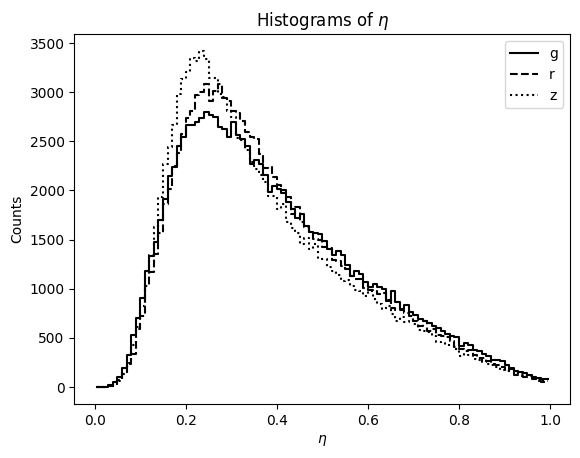

In [4]:
# Create mask and extract data
mask = data['quality_flag'] <= 3

nbins = 100
plt.figure()

# Create 1D histograms
x = data['eta_g'][mask]
hist, edges = np.histogram(x, bins=nbins, range=(0.0, 1.0))
centers = 0.5 * (edges[:-1] + edges[1:])
plt.plot(centers, hist, color='black',label='g',drawstyle='steps-mid')

x = data['eta_r'][mask]
hist, edges = np.histogram(x, bins=nbins, range=(0.0, 1.0))
centers = 0.5 * (edges[:-1] + edges[1:])
plt.plot(centers, hist, color='black',linestyle='dashed',label='r',drawstyle='steps-mid')

x = data['eta_z'][mask]
hist, edges = np.histogram(x, bins=nbins, range=(0.0, 1.0))
centers = 0.5 * (edges[:-1] + edges[1:])
plt.plot(centers, hist, color='black',linestyle='dotted',label='z',drawstyle='steps-mid')

plt.legend()

plt.xlabel('$\eta$')
plt.ylabel('Counts')
plt.title('Histograms of $\eta$')


Text(0, 0.5, 'SGA b/a')

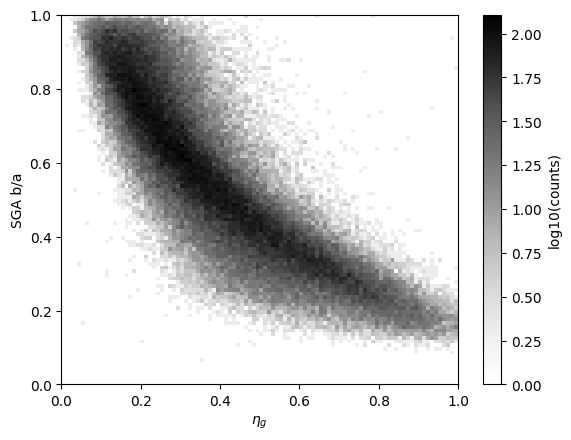

In [5]:
# build 2D histogram of eta_g vs BA_LEDA and plot with imshow
mask = (data['quality_flag']<=3)
x = data['eta_g'][mask]
y = data['BA_sga'][mask]

bins = [100, 100]
range_ = [[0.0, 1.0], [0.0, 1.0]]
H0, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range_)

# show as log-scaled image, transpose H so x maps to horizontal axis
plt.imshow(np.log10(H0.T + 1), origin='lower',
           extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
           aspect='auto', cmap=cm.Greys)
plt.colorbar(label='log10(counts)')
#plt.plot([0,1],[0,1],color='red',linestyle='--')
plt.axis([0.,1,0.,1.])
plt.xlabel('$\eta_g$')
plt.ylabel('SGA b/a')


/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'b/a SGA-derived Inclination [deg]')

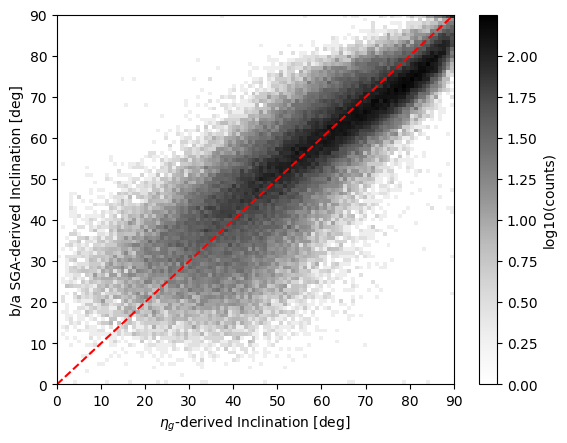

In [6]:
def ba_to_inclination(ba, q0=0.1):
    """Convert axis ratio to inclination in degrees."""
    cosi2 = (ba**2 - q0**2) / (1 - q0**2)
    cosi2 = np.clip(cosi2, 0, 1)  # avoid numerical issues
    incl = np.degrees(np.arccos(np.sqrt(cosi2)))
    return incl

def a2_to_inclination(a2, q0=0.25):
    """Convert axis ratio to inclination in degrees."""
    cosi = (1-a2+q0)**2.0
    #incl = np.degrees(np.arccos((1-q0)*cosi))
    incl = np.degrees(np.arccos((1-q0**2)*cosi))
    return incl

# build 2D histogram of eta_g vs BA_LEDA and plot with imshow
mask = (data['quality_flag']<=3)
x = a2_to_inclination(data['eta_g'][mask],q0=0.1)
y = ba_to_inclination(data['BA_sga'].values, q0=0.13)[mask]

bins = [100, 100]
range_ = [[0.0, 90.0], [0.0, 90.0]]
H0, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range_)

# show as log-scaled image, transpose H so x maps to horizontal axis
plt.imshow(np.log10(H0.T + 1), origin='lower',
           extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
           aspect='auto', cmap=cm.Greys)
plt.colorbar(label='log10(counts)')
plt.plot([0,90],[0,90],color='red',linestyle='--')
#plt.axis([0.,90,0.,90.])
plt.xlabel('$\eta_g$-derived Inclination [deg]')
plt.ylabel('b/a SGA-derived Inclination [deg]')


Text(0, 0.5, 'SGA-derived PA [deg]')

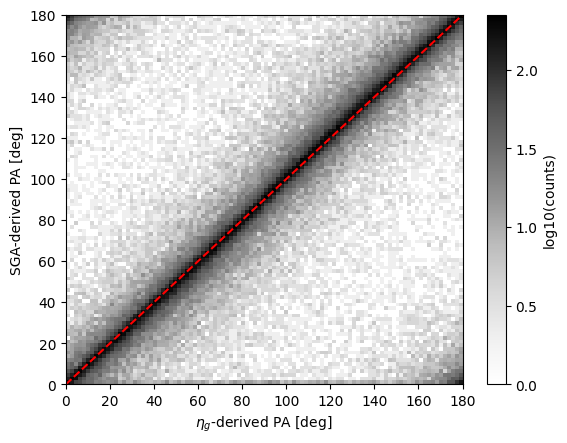

In [7]:
# build 2D histogram of eta_g vs BA_LEDA and plot with imshow
mask = (data['quality_flag']<=3)
x = data['pa_g'][mask]
y = data['PA_sga'][mask]

bins = [100, 100]
range_ = [[0.0, 180.0], [0.0, 180.0]]
H0, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range_)

# show as log-scaled image, transpose H so x maps to horizontal axis
plt.imshow(np.log10(H0.T + 1), origin='lower',
           extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
           aspect='auto', cmap=cm.Greys)
plt.colorbar(label='log10(counts)')
plt.plot([0,180],[0,180],color='red',linestyle='--')
plt.xlabel('$\eta_g$-derived PA [deg]')
plt.ylabel('SGA-derived PA [deg]')
